In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from collections import namedtuple

from definitions import ROOT_DIR
from unc.utils import load_info

In [26]:
all_paths = {
    '2_linear': Path(ROOT_DIR, 'results', '2_linear'),
    '2_nn':  Path(ROOT_DIR, 'results', '2_nn'),
    '2o_linear': Path(ROOT_DIR, 'results', '2o_linear'),
    '2o_nn': Path(ROOT_DIR, 'results', '2o_nn')
}

plot_info = {
    '2_linear': {'color': 'lightblue', 'label': 'Normal obs, linear'},
    '2_nn': {'color': 'blue', 'label': 'Normal obs, nn (hidden = 5)'},
    '2o_linear': {'color': 'rosybrown', 'label': 'Uncertainty trace obs, linear'},
    '2o_nn': {'color': 'brown', 'label': 'Uncertainty trace obs, nn (hidden = 5)'}
}

split_by = ['step_size']
Args = namedtuple('args', split_by)


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [13]:
def process_dir(dir_path, split_by):
    all_results = {}
        
    for f in tqdm(list(dir_path.iterdir())):
        info = load_info(f)
        args = info['args'].item()
        
        hparams = Args(*tuple(args[s] for s in split_by))

        if hparams not in all_results:
            all_results[hparams] = []

#         all_results[hparams].append((info['episode_reward'], args))
        all_results[hparams].append(info['episode_reward'])


    
    return all_results

In [15]:
raw_data = {}

for key, v in all_paths.items():
    processed = process_dir(v, split_by)
    
    raw_data[key] = {}
    for hparams, rew_lst in processed.items():
        raw_data[key][hparams] = np.stack(rew_lst)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [18]:
# Here we get our best hparams
all_best = {}
for key, res in raw_data.items():
    stats_list = []
    for args, rew in res.items():
        # we take mean over both time and seeds
        stats_list.append((args, rew.mean(), rew))
    all_best[key] = sorted(stats_list, key=lambda x: x[1])[-1]

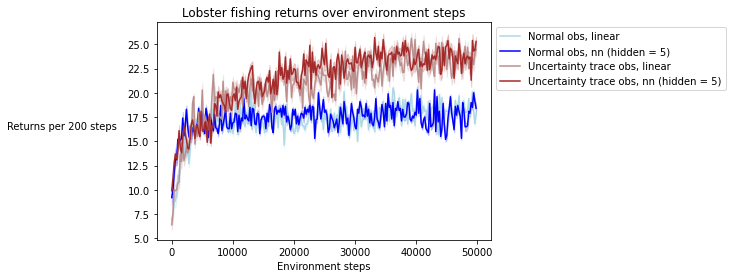

In [27]:
fig, ax = plt.figure(), plt.axes()
steps_per_eps = 200


for k, v in all_best.items():
    data = v[-1]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eps

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / data.shape[0]

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Returns per {steps_per_eps} steps", rotation=0, labelpad=65)
ax.set_title(f'Lobster fishing returns over environment steps')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')